In [1]:
## Test matrix operations
import numpy as np
A = np.array([[1,2,3],[4,5,6]]);
B = np.zeros(A.shape)
B[:,:] = A
B[1,:] -=  B[0,:]
A

array([[1, 2, 3],
       [4, 5, 6]])

In [2]:
import os;
from google.colab import drive
drive.mount('/content/drive', force_remount=True);

path = "/content/drive/Shared drives/Computational Optics Group/Yizhou_Lu_FLIM/DMD simulation";
os.chdir(path);
os.listdir(path);

Mounted at /content/drive


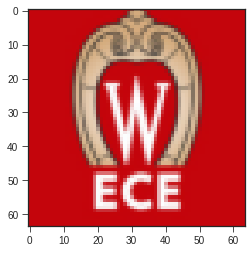

In [3]:
import numpy as np;
import matplotlib.pyplot as plt;
import matplotlib.image as mpimg;
plt.style.use(['seaborn-ticks'])
#plt.style.use(['classic'])

from PMT_compressed_sensing_simu import Compressed_sensing_PMT as CSP;
from YZ_masks import Haar_2d, Hyper_raster;

r = 64;
c = 64;

#########################################################
ratio_val = 0. ## to determine how many 1s in the masks!
Pnoise = True;
Gnoise = False;

Voxtel_camera = 25 * 256**2; ## the photon number per second for Vextel camera is 400
#########################################################

error = [];



pmt = CSP();
pmt.Load_img("ECE.jpg",RGB = True, size = (r,c), anti_aliasing = False);

In [4]:
def matrix_norm(A, norm = 1):
    if norm == 1:
        return np.max(np.sum(np.abs(A), axis = 0));
    elif norm == 2:
        _, s, _ = np.linalg.svd(A)
        return np.max(s);
        #return np.sum(np.sum(A**2, axis = 0)**0.5);
    elif norm == 'frob':
        return (np.sum(A**2))**0.5;
    elif norm == "inf":
        return np.max(np.sum(np.abs(A), axis = 1));

def Condition_number(A, inv_A = 'null', norm = 1):
    if inv_A == 'null':
        inv_A = np.linalg.pinv(A);
    return matrix_norm(A, norm = norm) * matrix_norm(inv_A, norm = norm);

In [5]:
'''
import numpy as np
A = np.array([[2, -1, 1], [1, 0, 1], [3, -1, 4]]);
B = np.array([[0.5, 1.5, -0.5], [-0.5, 2.5, -0.5], [-0.5, -0.5, 0.5]])
Condition_number(A, norm = "inf")
'''

'\nimport numpy as np\nA = np.array([[2, -1, 1], [1, 0, 1], [3, -1, 4]]);\nB = np.array([[0.5, 1.5, -0.5], [-0.5, 2.5, -0.5], [-0.5, -0.5, 0.5]])\nCondition_number(A, norm = "inf")\n'

In [7]:
norm_list = [1,2,'frob','inf']
## make masks
unity_basis = np.eye(r*c);
unity_inv = unity_basis;

unity_cond = {};
for norm in norm_list:
    unity_cond[norm] = Condition_number(unity_basis, unity_inv, norm);
print(unity_cond);

#print("Unity basis: the condition number is %.3e"%(Condition_number(unity_basis, unity_inv)));

residual_basis = np.ones((r*c,r*c)) - unity_basis;
residual_inv = np.linalg.pinv(residual_basis);

residual_cond = {};
for norm in norm_list:
    residual_cond[norm] = Condition_number(residual_basis, residual_inv, norm);
print(residual_cond);
#rint("Residual basis: the condition number is %.3e"%(Condition_number(residual_basis, residual_inv)));

## dct basis
pmt.Make_DMD_basis(r*c, scan_mode='Basis', ratio = 0);
dct_basis = pmt.DMD_basis;
dct_inv = np.linalg.pinv(dct_basis);

dct_cond = {};
for norm in norm_list:
    dct_cond[norm] = Condition_number(dct_basis, dct_inv, norm);
print(dct_cond);
#print("DCT basis: the condition number is %.3e"%(Condition_number(dct_basis, dct_inv)));

dct_basis_mod = np.zeros(dct_basis.shape);
dct_basis_mod[:,:] = dct_basis;
dct_basis_mod[0,:] -= dct_basis_mod[:,1];
dct_mod_inv = np.linalg.pinv(dct_basis_mod);

dct_mod_cond = {};
for norm in norm_list:
    dct_mod_cond[norm] = Condition_number(dct_basis_mod, dct_mod_inv, norm);
print(dct_mod_cond);
#print("DCT mod basis: the condition number is %.3e"%(Condition_number(dct_basis_mod, dct_mod_inv)));

random_basis = np.round(np.random.rand(r*c, r*c));
random_inv = np.linalg.pinv(random_basis);

random_cond = {};
for norm in norm_list:
    random_cond[norm] = Condition_number(random_basis, random_inv, norm);
print(random_cond);
#print("Random mod basis: the condition number is %.3e"%(Condition_number(random_basis, random_inv)));

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  


{1: 1.0, 2: 1.0, 'frob': 4096.0, 'inf': 1.0}
{1: 8189.0000004158255, 2: 4095.0000003121377, 'frob': 262080.00000188377, 'inf': 8189.000000422879}
{1: 12283.999999999187, 2: 2051.383807597936, 'frob': 8968.532658299302, 'inf': 13235.724717380652}
{1: 11967.947970216042, 2: 2425.8550104863566, 'frob': 9152.40639537315, 'inf': 17661.140638211626}
{1: 805585.6840004956, 2: 240464.46985060998, 'frob': 421804.83677059005, 'inf': 820629.4755470566}


In [ ]:
photons_per_second = 1e6;

maximum_time = 1e6;
data_density = 20;
time_list = (np.arange(data_density)+1)/data_density*maximum_time;
time_list = [1e-2, 1e-1,1e-0] + list(time_list);


In [ ]:
## unity recons:
## Before mask constant
_,_,layers = pmt.img.shape;
measure_unity = np.zeros((r*c,layers, len(time_list)));
Error_unity = np.zeros(len(time_list));
Error_residual = np.zeros(len(time_list));
Error_dct = np.zeros(len(time_list));
Error_dct_mod = np.zeros(len(time_list));
Error_random = np.zeros(len(time_list));

measure_residual = np.zeros((r*c, layers, len(time_list)));
measure_dct = np.zeros((r*c, layers, len(time_list)));
measure_dct_mod = np.zeros((r*c, layers, len(time_list))); ## DCT modified
measure_random = np.zeros((r*c, layers, len(time_list)));

for i in range(len(time_list)):
    pmt.YZ_process_bar((i+1)/len(time_list));
    time = time_list[i]
    n_photons = time * photons_per_second;
    light_level = n_photons / (r*c) * 2;
    measure_unity[:,:,i] = pmt.PMT_measure_simu(light_level, r*c, Poisson=True, upload_DMD_basis=unity_basis);
    measure_residual[:,:,i] = pmt.PMT_measure_simu(light_level, r*c, Poisson=True, upload_DMD_basis=residual_basis);
    measure_dct[:,:,i] = pmt.PMT_measure_simu(light_level, r*c, Poisson=True, upload_DMD_basis=dct_basis);
    measure_dct_mod[:,:,i] = pmt.PMT_measure_simu(light_level, r*c, Poisson=True, upload_DMD_basis=dct_basis_mod);

    measure_random[:,:,i] = pmt.PMT_measure_simu(light_level, r*c, Poisson=True, upload_DMD_basis=random_basis);

In [ ]:
## unity recons:
for time_index in range(len(time_list)):
    print(time_index, '/', len(time_list));
    pmt.PMT_direct_inverse_reconstruction(r, c, unity_inv, measure_unity[:,:,time_index], CS = False);
    recons_clipped = np.clip(pmt.img_reconstructed, a_min = 0,a_max = 1);
    this_error = (np.mean((recons_clipped - pmt.img)**2));
    
    
    Error_unity[time_index] = this_error;
plt.figure();
plt.plot(time_list, Error_unity);
plt.show();

In [ ]:
## Residual recons
for time_index in range(len(time_list)):
    print(time_index, '/', len(time_list));
    pmt.PMT_direct_inverse_reconstruction(r, c, residual_inv, measure_residual[:,:,time_index], CS = False);
    recons_clipped = np.clip(pmt.img_reconstructed, a_min = 0,a_max = 1);
    this_error = (np.mean((recons_clipped - pmt.img)**2));
    
    
    Error_residual[time_index] = this_error;
plt.figure();
plt.plot(time_list, Error_residual);
plt.show();

In [ ]:
## dct recons
for time_index in range(len(time_list)):
    print(time_index, '/', len(time_list));
    pmt.PMT_direct_inverse_reconstruction(r, c, dct_inv, measure_dct[:,:,time_index], CS = False);
    recons_clipped = np.clip(pmt.img_reconstructed, a_min = 0,a_max = 1);
    this_error = (np.mean((recons_clipped - pmt.img)**2));
    
    
    Error_dct[time_index] = this_error;
plt.figure();
plt.plot(time_list, Error_dct);
plt.show();

In [ ]:
## dct_mod recons
for time_index in range(len(time_list)):
    print(time_index, '/', len(time_list));
    pmt.PMT_direct_inverse_reconstruction(r, c, dct_mod_inv, measure_dct_mod[:,:,time_index], CS = False);
    recons_clipped = np.clip(pmt.img_reconstructed, a_min = 0,a_max = 1);
    this_error = (np.mean((recons_clipped - pmt.img)**2));
    
    
    Error_dct_mod[time_index] = this_error;
plt.figure();
plt.plot(time_list, Error_dct_mod);
plt.show();

In [ ]:
## random
for time_index in range(len(time_list)):
    print(time_index, '/', len(time_list));
    pmt.PMT_direct_inverse_reconstruction(r, c, random_inv, measure_random[:,:,time_index], CS = False);
    recons_clipped = np.clip(pmt.img_reconstructed, a_min = 0,a_max = 1);
    this_error = (np.mean((recons_clipped - pmt.img)**2));
    
    
    Error_random[time_index] = this_error;
plt.figure();
plt.plot(time_list, Error_random);
plt.show();

In [ ]:
plt.figure();
plt.plot(time_list, np.log10(Error_unity), label = "Unity");
plt.plot(time_list, np.log10(Error_residual), label = "Residual");
plt.plot(time_list, np.log10(Error_dct), label = "DCT_ceil");
plt.plot(time_list, np.log10(Error_dct_mod), label = "DCT_ceil_mod");
plt.plot(time_list, np.log10(Error_random), label = "Random");
plt.legend();
plt.xlabel("Time/Second");
plt.ylabel("log10(MSE)");
plt.show();

In [ ]:
plt.figure();
plt.plot(time_list, (Error_unity), label = "Unity");
plt.plot(time_list, (Error_residual), label = "Residual");
plt.plot(time_list, (Error_dct), label = "DCT_ceil");
plt.plot(time_list, (Error_dct_mod), label = "DCT_ceil_mod");
plt.plot(time_list, (Error_random), label = "Random");
plt.legend();
plt.xlabel("Time/Second");
plt.ylabel("(MSE)");
plt.show();

## Theory

In [ ]:
np.mean(Error_dct >= Error_dct_mod)

In [ ]:
0.55;
0.5;
0.45;
0.6;